# 数据加载
从CSV文件中加载所需的数据集。这些数据集分别包含关于分拣中心的每日货量、每小时货量、分拣中心之间的路线信息，以及路线的变更信息。
- **data_daily**: 每日数据，可能包含每天的货量统计。
- **data_hourly**: 每小时数据，详细到每小时的货量变化。
- **data_routes**: 分拣中心间的常规路线数据，显示常规的货物流动路径。
- **data_routes_changes**: 路线变更数据，显示最近的路线添加或修改。

In [1]:
import pandas as pd

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

data_daily = load_data('附件1.csv')
data_hourly = load_data('附件2.csv')
data_routes = load_data('附件3.csv')
data_routes_changes = load_data('附件4.csv')

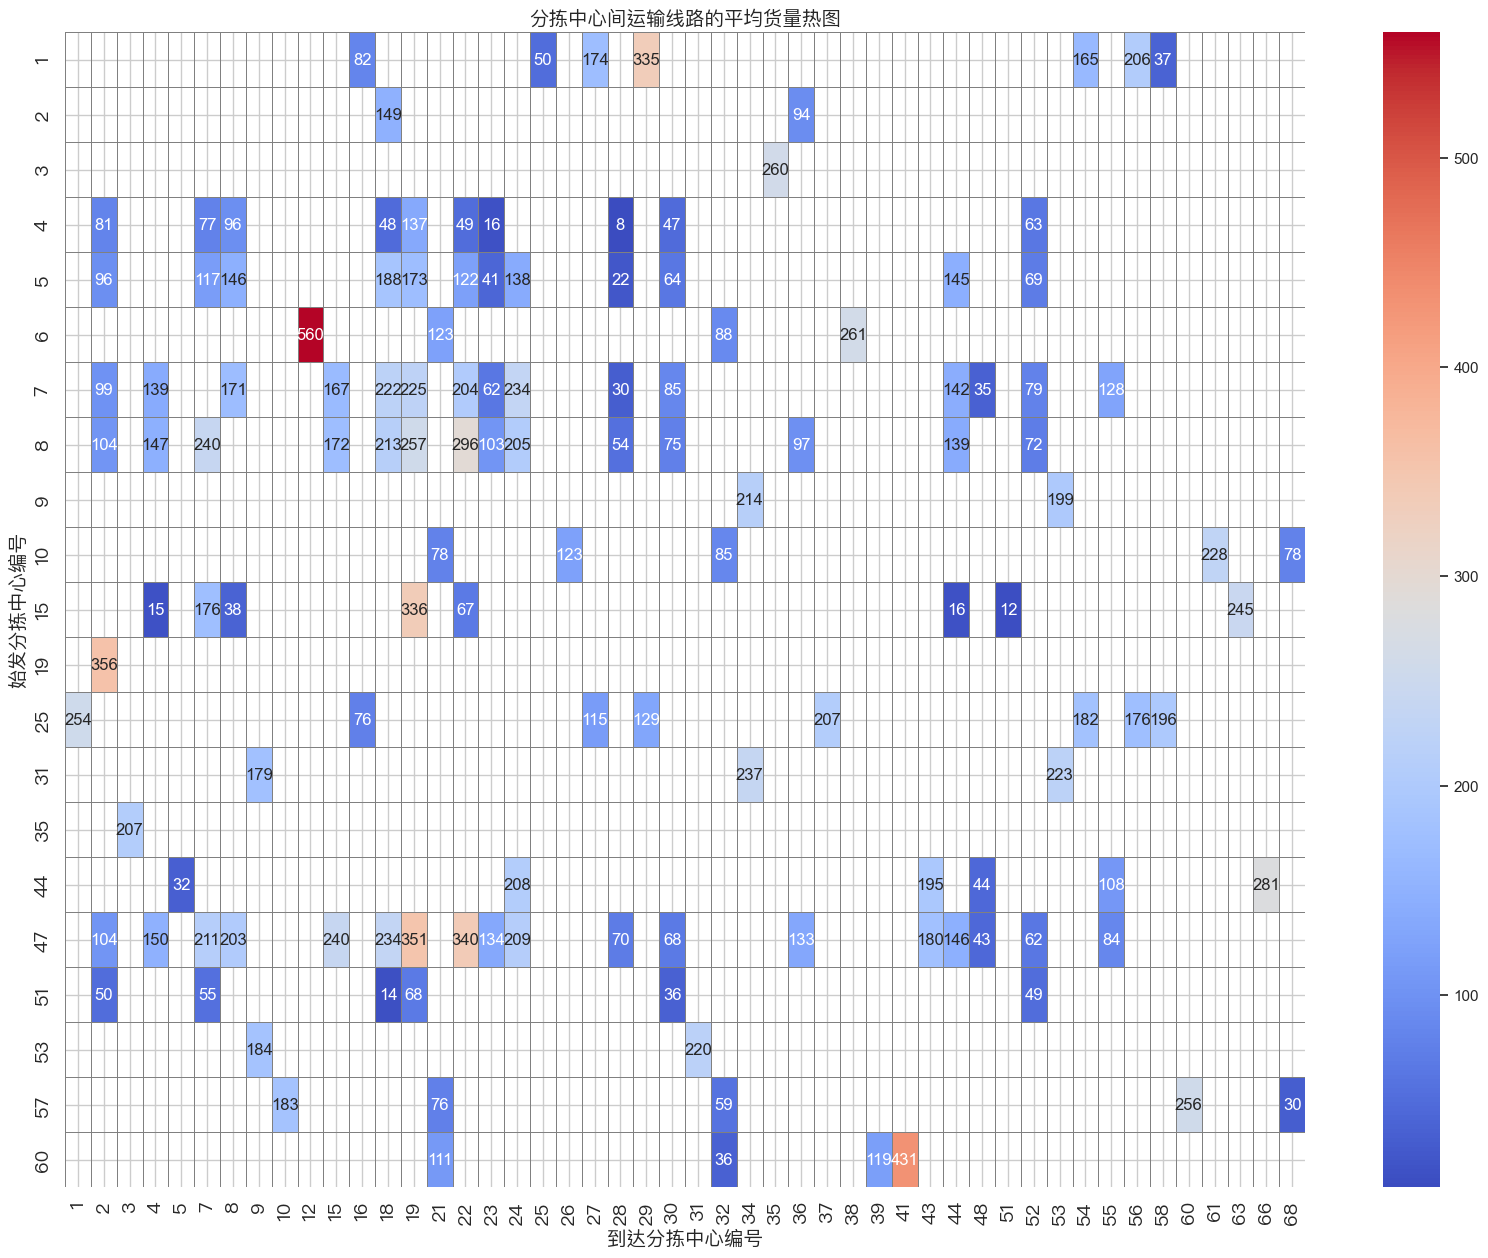

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties

font_path = '/System/Library/Fonts/PingFang.ttc'
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False  

data_routes['始发分拣中心编号'] = data_routes['始发分拣中心'].str.extract('(\d+)').astype(int)
data_routes['到达分拣中心编号'] = data_routes['到达分拣中心'].str.extract('(\d+)').astype(int)

pivot_table = data_routes.pivot_table(index='到达分拣中心编号', columns='始发分拣中心编号', values='货量', aggfunc='mean')

sns.set(style="whitegrid")

plt.figure(figsize=(20, 15))
ax = sns.heatmap(pivot_table, annot=True, fmt="g", cmap='coolwarm', linewidths=.5, linecolor='gray')

my_font = FontProperties(fname=font_path, size=14)

ax.set_xlabel('到达分拣中心编号', fontproperties=my_font)  
ax.set_ylabel('始发分拣中心编号', fontproperties=my_font)  
plt.title('分拣中心间运输线路的平均货量热图', fontproperties=my_font)  

plt.xticks(rotation=90, fontproperties=my_font)
plt.yticks(fontproperties=my_font)

plt.show()


这张图片简要概括一下就好，这个是对于原始数据集的可视化

In [5]:
data_daily = load_data('附件1.csv')
data_hourly = load_data('附件2.csv')
data_routes = load_data('附件3.csv')
data_routes_changes = load_data('附件4.csv')


# 数据合并
利用Pandas的merge函数，将变更的路线数据与现有路线数据进行合并。过滤出有效的、有更新的路线数据。

In [6]:
data_routes_changes_count = pd.merge(data_routes_changes, data_routes, on=['始发分拣中心', '到达分拣中心'], how='inner')

data_routes_changes_count

,始发分拣中心,到达分拣中心,货量
0,SC7,SC8,240
1,SC30,SC8,75
2,SC22,SC8,296
3,SC44,SC8,139
4,SC4,SC8,147
...,...,...,...
115,SC66,SC44,281
116,SC35,SC3,260
117,SC9,SC53,184
118,SC31,SC53,220


In [7]:
data_routes_changes.set_index(['始发分拣中心', '到达分拣中心'], inplace=True)
data_routes_changes_count.set_index(['始发分拣中心', '到达分拣中心'], inplace=True)
result = data_routes_changes.merge(data_routes_changes_count, how='left', left_index=True, right_index=True, indicator=True)
new_routes = result[result['_merge'] == 'left_only']

new_routes.reset_index(inplace=True)

print(new_routes[['始发分拣中心', '到达分拣中心']])

  始发分拣中心 到达分拣中心
0    SC5    SC4
1   SC31    SC9


# 网络图构建和可视化
构建有向图，其中每个节点代表一个分拣中心，每条边代表两个分拣中心间的货量。
- 使用networkx的DiGraph来创建有向图，确保货量流动的方向性得以表示。
- 将分拣中心编号排序，并在网格上可视化，以便更清楚地识别模式和流量的集中点。

# 网络图和图论

网络图（或图）由节点（顶点）和边（链接节点的线）组成。在物流网络中，节点可以代表分拣中心，边代表分拣中心之间的货物流动。

## 图的表示

- **邻接矩阵**：一个n x n的矩阵，其中n是节点的数量。矩阵的元素a[i][j]表示从节点i到节点j的边的权重（在此案例中是货量）。
- **边列表**：每条边由一个节点对和权重表示，形如(i, j, w)，其中i是起始节点，j是终止节点，w是权重（货量）。
  
在本案例中，networkx使用边列表来构建图。

## 网格布局

- **位置计算**：每个节点被放置在网格的特定位置，使用二维坐标表示。

/var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/ipykernel_18378/2834725087.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='货量')
/Users/yooky/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36135 (\N{CJK UNIFIED IDEOGRAPH-8D27}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yooky/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


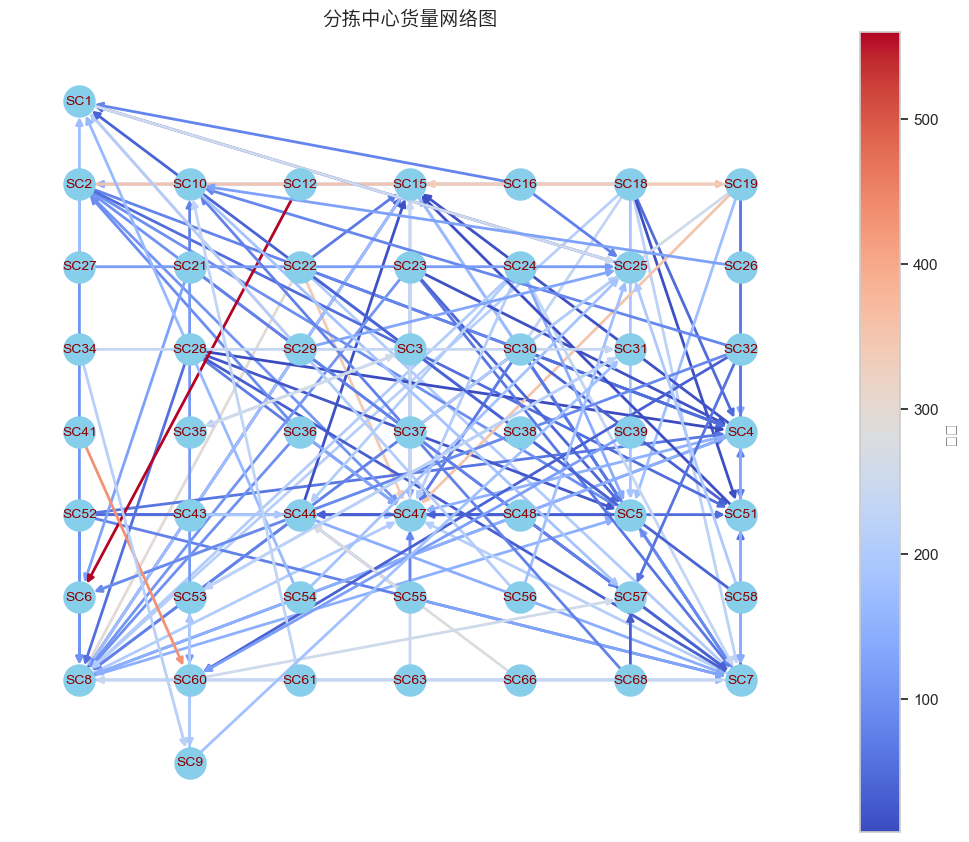

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 创建有向图
data_routes = pd.read_csv('附件3.csv')
G = nx.from_pandas_edgelist(data_routes, '始发分拣中心', '到达分拣中心', ['货量'], create_using=nx.DiGraph())

# 定位节点
nodes = sorted(G.nodes())
grid_side = int(np.sqrt(len(nodes)))  # 计算网格大小
pos = {node: (i % grid_side, -i // grid_side) for i, node in enumerate(nodes)}

# 设置图形和颜色映射
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=min((d['货量'] for u, v, d in G.edges(data=True))),
                         vmax=max((d['货量'] for u, v, d in G.edges(data=True))))

# 绘制网络
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, 
        edge_color=[cmap(norm(d['货量'])) for u, v, d in G.edges(data=True)], 
        width=2, arrowstyle='-|>', arrowsize=10, font_size=10, font_color='darkred')

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='货量')

plt.title('分拣中心货量网络图', fontsize=14, fontproperties=my_font)
plt.show()



# 最大流算法
应用最大流算法来估算从一个特定分拣中心（源点）到另一个分拣中心（汇点）的最大可能货量。这种方法可以帮助物流公司了解在当前网络容量限制下的最大运输能力，从而进行适当的资源分配和路径规划。

networkx实现的最大流函数通常使用Edmonds-Karp算法，这是Ford-Fulkerson方法的一种实现。Edmonds-Karp算法是Ford-Fulkerson方法的一种特定版本，它使用广度优先搜索（BFS）来查找增广路径，这种方法确保了在多项式时间内解决问题。

## Ford-Fulkerson 方法

这是求解最大流问题的一种方法，它使用以下步骤：

1. **初始化流量**：最初，所有边的流量都设置为0。
2. **增广路径**：找到一条从S到T的路径，沿该路径还能够增加流量（即边的容量大于当前流量）。
3. **路径流量**：沿找到的路径增加尽可能多的流量，直到达到某条边的容量限制。


In [14]:
data_routes = pd.read_csv('附件3.csv')  # 确保路径正确

# 创建有向图
G = nx.DiGraph()

# 添加边和权重
for index, row in data_routes.iterrows():
    G.add_edge(row['始发分拣中心'], row['到达分拣中心'], capacity=row['货量'])

# 定义源节点和汇点
source = 'SC5'
target = 'SC4' 

# 使用最大流算法计算最大流
flow_value, flow_dict = nx.maximum_flow(G, source, target)

print("最大流值:", flow_value)


最大流值: 32


In [15]:
source = 'SC31' 
target = 'SC9'

# 使用最大流算法计算最大流
flow_value, flow_dict = nx.maximum_flow(G, source, target)

print("最大流值:", flow_value)


最大流值: 199


In [16]:
data_routes_changes_count = pd.merge(data_routes_changes, data_routes, on=['始发分拣中心', '到达分拣中心'], how='inner')

new_data = pd.DataFrame({
    '始发分拣中心': ['SC5', 'SC31'],
    '到达分拣中心': ['SC4', 'SC9'],
    '货量': [32, 199]
})

In [17]:
day_df = pd.read_csv('结果1.csv')

centers_list = day_df['分拣中心'].unique()

new_data_a = new_data.groupby('到达分拣中心')['货量'].sum()
new_data_d = new_data.groupby('始发分拣中心')['货量'].sum()
data_routes_changes_count_a = data_routes_changes_count.groupby('到达分拣中心')['货量'].sum()
data_routes_changes_count_d = data_routes_changes_count.groupby('始发分拣中心')['货量'].sum()


for center in centers_list:
    delta_new_a = new_data_a.get(center, 0) 
    delta_new_d = new_data_d.get(center, 0)
    delta_old_a = data_routes_changes_count_a.get(center, 0)
    delta_old_d = data_routes_changes_count_d.get(center, 0)
    
    delta_a = delta_new_a - delta_old_a
    delta_d = delta_new_d - delta_old_d
    
    day_df.loc[day_df['分拣中心'] == center, '货量'] += delta_a - delta_d

print(day_df.head())


   分拣中心          日期   货量
0  SC48  2023/12/01  877
1  SC48  2023/12/02  912
2  SC48  2023/12/03  912
3  SC48  2023/12/04  912
4  SC48  2023/12/05  912


In [18]:
import pandas as pd
import numpy as np

hour_df = pd.read_csv('结果2.csv')
new_data_a = new_data.groupby('到达分拣中心')['货量'].sum() / 24
new_data_d = new_data.groupby('始发分拣中心')['货量'].sum() / 24
data_routes_changes_a = data_routes_changes_count.groupby('到达分拣中心')['货量'].sum() / 24
data_routes_changes_d = data_routes_changes_count.groupby('始发分拣中心')['货量'].sum() / 24

for center in hour_df['分拣中心'].unique():
    delta_new_a = new_data_a.get(center, 0)  
    delta_new_d = new_data_d.get(center, 0)
    delta_old_a = data_routes_changes.get(center, 0)
    delta_old_d = data_routes_changes.get(center, 0)
    
    delta_a = delta_new_a - delta_old_a
    delta_d = delta_new_d - delta_old_d
    
    hour_df.loc[hour_df['分拣中心'] == center, '货量'] += delta_a - delta_d

hour_df['货量'] = np.ceil(hour_df['货量'])
print(hour_df.head())

   分拣中心          日期  小时     货量
0  SC54  2023/12/01   0  238.0
1  SC54  2023/12/01   1  196.0
2  SC54  2023/12/01   2  193.0
3  SC54  2023/12/01   3  185.0
4  SC54  2023/12/01   4  184.0


In [19]:
day_df.to_csv('结果3.csv',index=False)
hour_df.to_csv('结果4.csv',index=False)

## 根据关键词：网络图、图论、最大流算法、Ford-Fulkerson方法查找相关文献、公式丰富论文